# Fraud Detection with Anomaly Detection using Autoencoders, Isolation Forests, and Ensemble Methods



In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Load and Preprocess Transaction Data



In [5]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   



In [6]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

print("\nData types of each column:")
print(df.dtypes)

Missing values in each column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Data types of each column:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int6

## Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = df.drop('Time', axis=1)


X = df.drop('Class', axis=1)
y = df['Class']

scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Split normal transactions into train and test sets
X_normal = X[y == 0]
y_normal = y[y == 0]
X_fraud = X[y == 1]
y_fraud = y[y == 1]


X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=42, stratify=None
)

# Combine test normal data with all fraud data for final test set
X_test = pd.concat([X_normal_test, X_fraud])
y_test = pd.concat([y_normal_test, y_fraud])


X_train = X_normal_train
y_train = y_normal_train

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Fraud cases in training: {y_train.sum()}")
print(f"Fraud cases in test: {y_test.sum()}")
print(f"Test set fraud rate: {y_test.sum() / len(y_test):.4f}")

Training data shape: (227452, 29)
Test data shape: (57355, 29)
Fraud cases in training: 0
Fraud cases in test: 492
Test set fraud rate: 0.0086


## Data Visualization



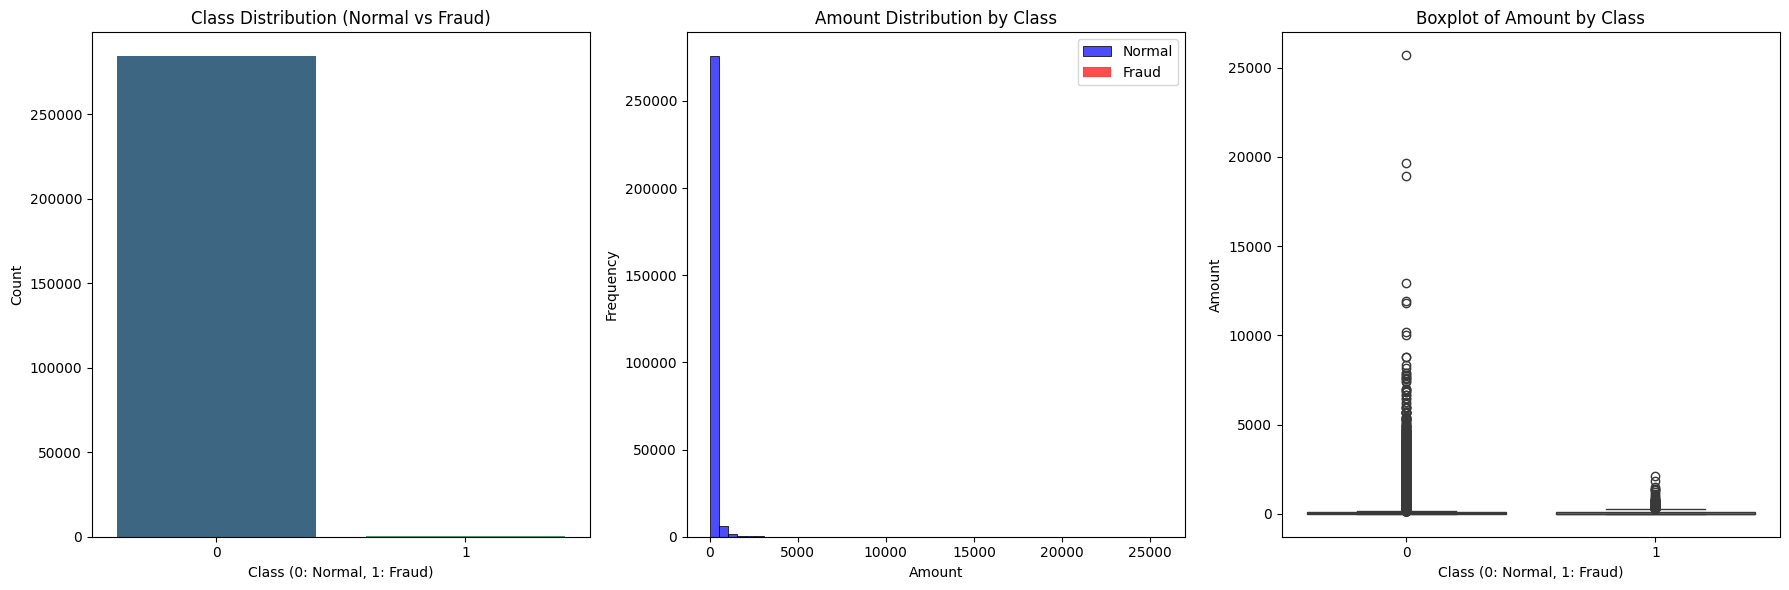

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Class distribution
sns.countplot(x='Class', data=df, hue='Class', palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Class Distribution (Normal vs Fraud)')
axes[0].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[0].set_ylabel('Count')

# Amount distribution by class
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, label='Normal', alpha=0.7, color='blue', ax=axes[1])
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, label='Fraud', alpha=0.7, color='red', ax=axes[1])
axes[1].legend()
axes[1].set_title('Amount Distribution by Class')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')

# Boxplot of Amount by Class
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', palette='viridis', legend=False, ax=axes[2])
axes[2].set_title('Boxplot of Amount by Class')
axes[2].set_xlabel('Class (0: Normal, 1: Fraud)')
axes[2].set_ylabel('Amount')

plt.tight_layout()
plt.show()



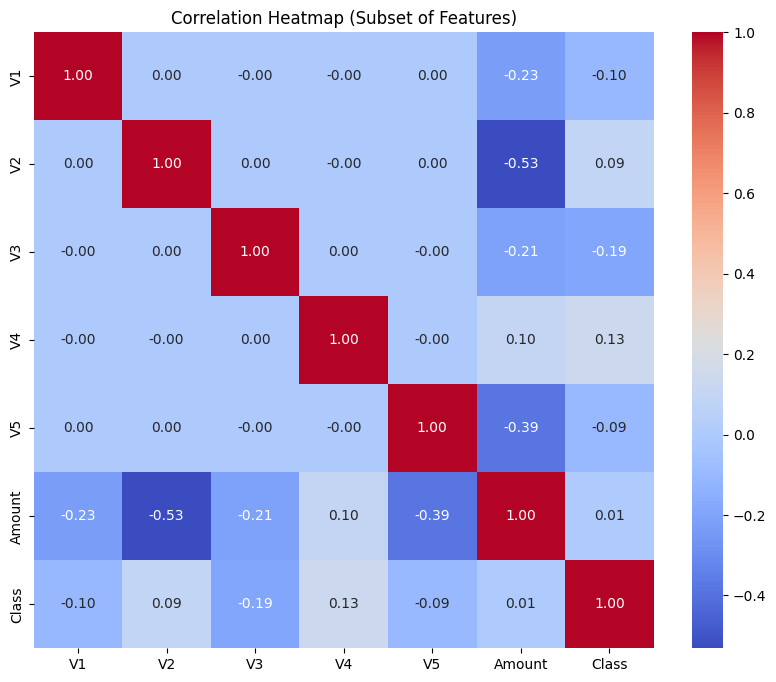

In [51]:
# Correlation heatmap for a subset of features (including Amount and first few V features)
subset_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'Amount', 'Class']
plt.figure(figsize=(10, 8))
corr_matrix = df[subset_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Subset of Features)')
plt.show()

## Perform Feature Engineering



In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Fit polynomial features only on training data
poly = PolynomialFeatures(degree=2, include_bias=False)
amount_poly_train = poly.fit_transform(X_train[['Amount']])
amount_poly_train_df = pd.DataFrame(amount_poly_train, columns=['Amount', 'Amount^2'], index=X_train.index)

amount_poly_test = poly.transform(X_test[['Amount']])
amount_poly_test_df = pd.DataFrame(amount_poly_test, columns=['Amount', 'Amount^2'], index=X_test.index)


X_train = pd.concat([X_train.drop('Amount', axis=1), amount_poly_train_df], axis=1)
X_test = pd.concat([X_test.drop('Amount', axis=1), amount_poly_test_df], axis=1)

print(f"Features after engineering: {X_train.shape[1]}")
print("Feature names:", X_train.columns.tolist())
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Features after engineering: 30
Feature names: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Amount^2']
Training data shape: (227452, 30)
Test data shape: (57355, 30)


## Build and Train Autoencoder Model



Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - loss: 0.9655 - val_loss: 18.8472
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - loss: 0.8507 - val_loss: 19.9186
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - loss: 0.8971 - val_loss: 47.7330
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - loss: 0.8878 - val_loss: 23.7223
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - loss: 0.9349 - val_loss: 16.4451
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - loss: 0.9847 - val_loss: 12.0488
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 0.8612 - val_loss: 16.8973
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - loss: 0.8753 - val_loss: 6.4191
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - loss: 0.8970 - val_loss: 7.6942
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - loss: 0.7680 - val_loss: 18.6980
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 1.1048 - val_loss: 29.0562
Epoch 12/50
800/800 ━

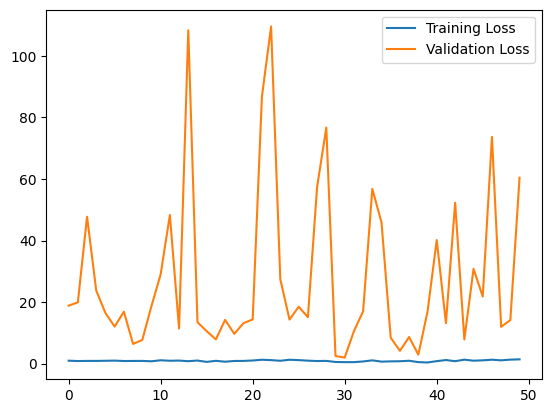

In [ ]:
input_dim = X_train.shape[1]

input_layer = layers.Input(shape=(input_dim,))
# Encoder layers
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
# Decoder layers
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

# Build the autoencoder model
autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder on normal transactions
history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          validation_split=0.1, 
                          verbose=1,
                          shuffle=True)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

## Detect Anomalies Using Autoencoder


1793/1793 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
1793/1793 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
Reconstruction error threshold: 6.1745
Autoencoder Anomaly Detection Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.33      0.55      0.41       492

    accuracy                           0.99     57355
   macro avg       0.66      0.77      0.70     57355
weighted avg       0.99      0.99      0.99     57355

ROC AUC Score: 0.9371
Reconstruction error threshold: 6.1745
Autoencoder Anomaly Detection Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.33      0.55      0.41       492

    accuracy                           0.99     57355
   macro avg       0.66      0.77      0.70     57355
weighted avg       0.99      0.99      0.99

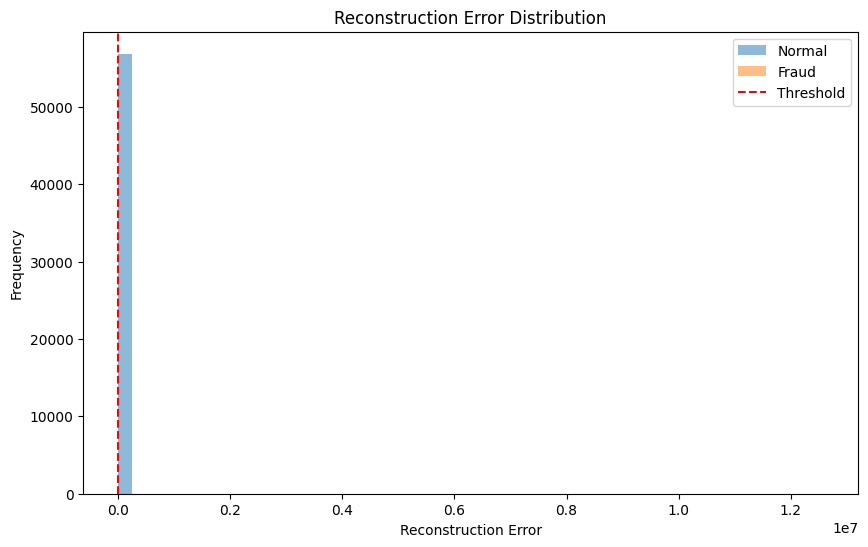

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score 

# Compute reconstruction errors on test data
X_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test.values - X_pred, 2), axis=1)


train_pred = autoencoder.predict(X_train)
train_error = np.mean(np.power(X_train.values - train_pred, 2), axis=1)
threshold = np.percentile(train_error, 99)  

print(f"Reconstruction error threshold: {threshold:.4f}")

# Classify anomalies
y_pred_ae = (reconstruction_error > threshold).astype(int)

# Evaluate the autoencoder
print("Autoencoder Anomaly Detection Results:")
print(classification_report(y_test, y_pred_ae))
print(f"ROC AUC Score: {roc_auc_score(y_test, reconstruction_error):.4f}")

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.5, label='Fraud')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.show()

## Build and Train Isolation Forest Model


In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize and train Isolation Forest 
fraud_rate = y.sum() / len(y) 
iso_forest = IsolationForest(n_estimators=100, contamination=fraud_rate * 1.2, random_state=42)  # Increased by 20% for tuning
iso_forest.fit(X_train)

print("Isolation Forest model trained on normal transactions.")

Isolation Forest model trained on normal transactions.


## Detect Anomalies Using Isolation Forest


Isolation Forest Anomaly Detection Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56863
           1       0.50      0.22      0.31       492

    accuracy                           0.99     57355
   macro avg       0.75      0.61      0.65     57355
weighted avg       0.99      0.99      0.99     57355

ROC AUC Score: 0.9476


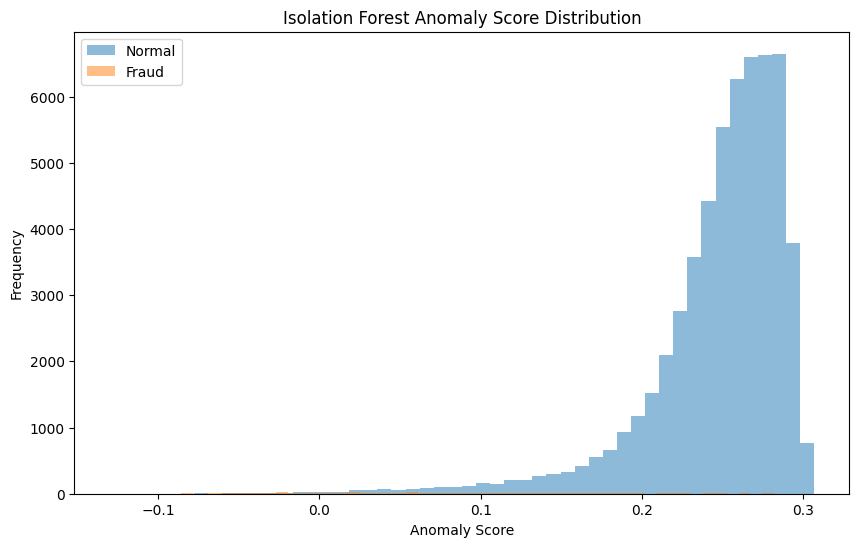

In [11]:
# Compute anomaly scores and predictions
iso_scores = iso_forest.decision_function(X_test)  # Higher scores indicate normal transactions
y_pred_if = (iso_forest.predict(X_test) == -1).astype(int)  # 1 for anomalies

# Evaluate Isolation Forest
print("Isolation Forest Anomaly Detection Results:")
print(classification_report(y_test, y_pred_if))
print(f"ROC AUC Score: {roc_auc_score(y_test, -iso_scores):.4f}")  # Negate scores for AUC calculation

# Plot anomaly score distribution
plt.figure(figsize=(10, 6))
plt.hist(iso_scores[y_test == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(iso_scores[y_test == 1], bins=50, alpha=0.5, label='Fraud')
plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Isolation Forest Anomaly Score Distribution')
plt.show()

## Implement Ensemble Method for Anomaly Detection

Ensemble Anomaly Detection Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56863
           1       0.46      0.27      0.34       492

    accuracy                           0.99     57355
   macro avg       0.73      0.63      0.67     57355
weighted avg       0.99      0.99      0.99     57355

ROC AUC Score: 0.9476


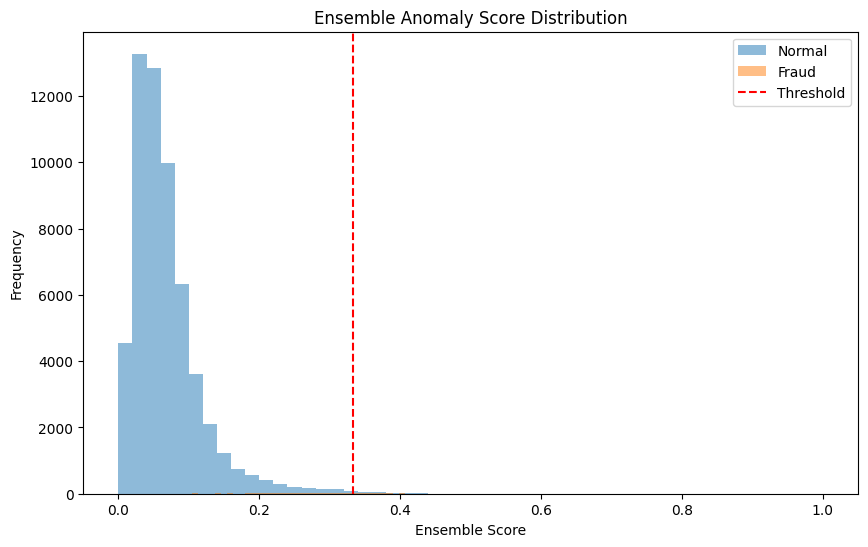

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_ae = MinMaxScaler()
ae_scores_norm = scaler_ae.fit_transform(reconstruction_error.reshape(-1, 1)).flatten()

scaler_if = MinMaxScaler()
if_scores_norm = scaler_if.fit_transform((-iso_scores).reshape(-1, 1)).flatten()  # Negate IF scores to align with anomaly direction

ensemble_scores = (ae_scores_norm + if_scores_norm) / 2

# Set threshold for ensemble 
ensemble_threshold = np.percentile(ensemble_scores, 99.5)
y_pred_ensemble = (ensemble_scores > ensemble_threshold).astype(int)

# Evaluate ensemble method
print("Ensemble Anomaly Detection Results:")
print(classification_report(y_test, y_pred_ensemble))
print(f"ROC AUC Score: {roc_auc_score(y_test, ensemble_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.hist(ensemble_scores[y_test == 0], bins=50, alpha=0.5, label='Normal')
plt.hist(ensemble_scores[y_test == 1], bins=50, alpha=0.5, label='Fraud')
plt.axvline(ensemble_threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Ensemble Score')
plt.ylabel('Frequency')
plt.title('Ensemble Anomaly Score Distribution')
plt.show()

## Evaluate and Visualize Detection Results

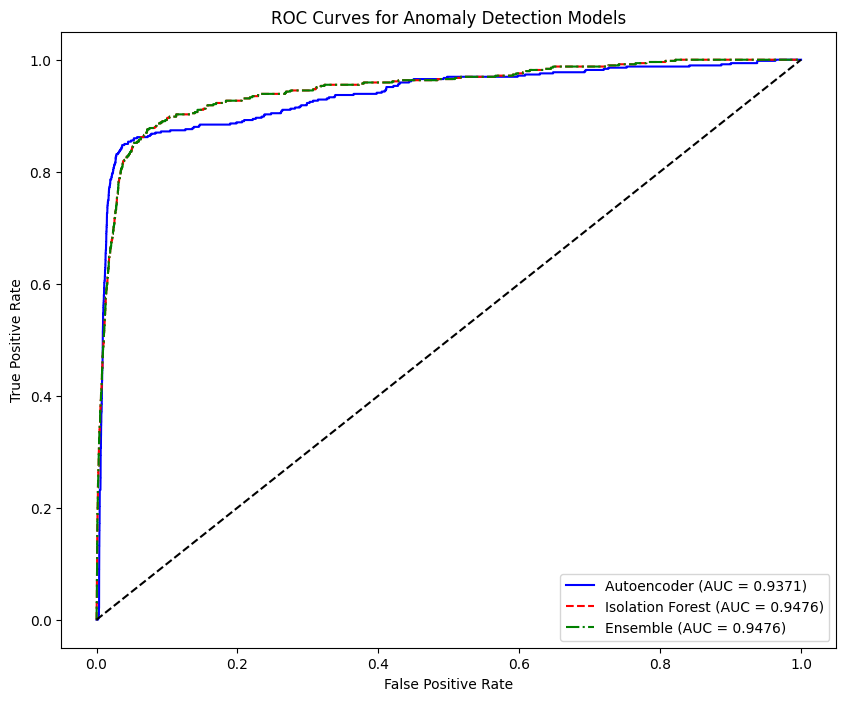

In [13]:
# Plot ROC Curves for all models
from sklearn.metrics import roc_curve

fpr_ae, tpr_ae, _ = roc_curve(y_test, reconstruction_error)
fpr_if, tpr_if, _ = roc_curve(y_test, -iso_scores)
fpr_en, tpr_en, _ = roc_curve(y_test, ensemble_scores)

plt.figure(figsize=(10, 8))
plt.plot(fpr_ae, tpr_ae, label=f'Autoencoder (AUC = {roc_auc_score(y_test, reconstruction_error):.4f})', color='blue', linestyle='-')
plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {roc_auc_score(y_test, -iso_scores):.4f})', color='red', linestyle='--')
plt.plot(fpr_en, tpr_en, label=f'Ensemble (AUC = {roc_auc_score(y_test, ensemble_scores):.4f})', color='green', linestyle='-.')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Models')
plt.legend()
plt.show()

